In [1]:
import pandas as pd
import datetime as dt
from pyseas.contrib import plot_gap

%matplotlib inline

# Code to create a visualization for a single gap.

Swap out the gap_id below and run the whole script

In [2]:
gaps_table = 'world-fishing-827.proj_ais_gaps_catena.raw_gaps_with_ee_stats_v20201031'
#gaps_table = 'world-fishing-827.proj_ais_gaps_catena.raw_gaps_v20201031' # Use if you don't care about Exact Earth positions
gap_id = 'd380708e4e604791596e44d64c564f76'

In [3]:
q = f'''
SELECT
  *
FROM
  `{gaps_table}`   
WHERE
  gap_id = \'{gap_id}\'
'''

df_gaps = pd.read_gbq(q, project_id='world-fishing-827', dialect='standard')

/Users/jennifervanosdel/miniconda3/envs/gfw-viz/lib/python3.8/site-packages/pyarrow/util.py:39: FutureWarning: pyarrow.read_schema is deprecated as of 0.17.0, please use pyarrow.ipc.read_schema instead
  warnings.warn(msg, FutureWarning)
/Users/jennifervanosdel/miniconda3/envs/gfw-viz/lib/python3.8/site-packages/pyarrow/util.py:39: FutureWarning: pyarrow.read_record_batch is deprecated as of 0.17.0, please use pyarrow.ipc.read_record_batch instead
  warnings.warn(msg, FutureWarning)


In [4]:
df_gaps

,ssvid,gap_id,gap_start,gap_end,off_class,on_class,off_receiver_type,on_receiver_type,vessel_class,vessel_length_m,...,time_since_last_ee_pos,time_until_first_ee_pos,ee_positions,ee_positions_invalid,ee_positions_over_1hr,ee_positions_over_4hr,ee_positions_over_6hr,max_ee_gap,max_gap,gap_in_ee
0,416000301,d380708e4e604791596e44d64c564f76,2018-12-25 11:40:42+00:00,2018-12-26 04:25:31+00:00,A,A,satellite,satellite,drifting_longlines,23.6,...,0.001667,0.003333,63,0,0,0,0,16.574444,16.574444,True


#### Get key attributes from the gap

In [5]:
assert(df_gaps.shape[0] == 1)
gap = df_gaps.iloc[0]
start_date = gap.gap_start
end_date = gap.gap_end
gap_in_ee = gap.gap_in_ee

# Get the GFW positions for the gap

Restrict the query by the gap start and end times to reduce size

Size: ~10GB

In [6]:
q = f'''
DECLARE start_date TIMESTAMP DEFAULT \'{start_date}\';
DECLARE end_date TIMESTAMP DEFAULT \'{end_date}\';

WITH

  good_segs AS (
    SELECT
        seg_id
    FROM
        `gfw_research.pipe_v20190502_segs`
    WHERE
        good_seg
        AND NOT overlapping_and_short),
    
  gaps AS (
    SELECT
        ssvid,
        gap_start,
        gap_end,
        off_lat,
        off_lon,
        on_lat,
        on_lon,
        positions_per_day_off,
        vessel_class,
        gap_hours,
        gap_id,
        off_class,
        flag,
        off_distance_from_shore_m
    FROM
        `{gaps_table}`
    WHERE
        gap_id = \'{gap_id}\'
    )

SELECT
  a.ssvid ssvid,
  gap_id,
  lat,
  lon,
  timestamp,
  speed_knots,
  course,
  receiver_type,
  night
FROM
  `gfw_research.pipe_v20190502_fishing` a
JOIN
  gaps b
ON
  a.ssvid = b.ssvid
  AND a.timestamp BETWEEN TIMESTAMP_SUB (gap_start,
    INTERVAL 2 DAY)
  AND TIMESTAMP_ADD(gap_end, INTERVAL 2 DAY)
WHERE
  date BETWEEN TIMESTAMP_SUB(start_date, INTERVAL 2 day)
  AND TIMESTAMP_ADD(end_date, INTERVAL 2 day)
  AND seg_id IN (
  SELECT
    *
  FROM
    good_segs)
ORDER BY
  ssvid,
  gap_id,
  timestamp
'''

df_gap_positions_gfw = pd.read_gbq(q, project_id='world-fishing-827', dialect='standard')

/Users/jennifervanosdel/miniconda3/envs/gfw-viz/lib/python3.8/site-packages/pyarrow/util.py:39: FutureWarning: pyarrow.read_schema is deprecated as of 0.17.0, please use pyarrow.ipc.read_schema instead
  warnings.warn(msg, FutureWarning)
/Users/jennifervanosdel/miniconda3/envs/gfw-viz/lib/python3.8/site-packages/pyarrow/util.py:39: FutureWarning: pyarrow.read_record_batch is deprecated as of 0.17.0, please use pyarrow.ipc.read_record_batch instead
  warnings.warn(msg, FutureWarning)


# Get the Exact Earth positions for the gap, if the gap has Exact Earth data

Restrict the query by the gap start and end times to reduce size

Size: ~2GB

In [7]:
q = f'''
DECLARE start_date TIMESTAMP DEFAULT \'{start_date}\';
DECLARE end_date TIMESTAMP DEFAULT \'{end_date}\';

WITH
    
  gap_info AS (
    SELECT
        ssvid,
        gap_id,
        gap_start,
        gap_end
    FROM
        `{gaps_table}`
    WHERE
        gap_id = \'{gap_id}\'
  ),

  ee AS(
  (SELECT 
    timestamp,
    MMSI as ssvid,
    Latitude as lat,
    Longitude as lon,
    (CASE WHEN Message_ID IN ('1','2','3') THEN 'A'
          WHEN Message_ID IN ('18','19') THEN 'B' END) as class
  FROM `world-fishing-827.ais_exact_earth.2019_csv_data_formated_and_partitioned`
  WHERE timestamp BETWEEN TIMESTAMP_SUB(start_date, INTERVAL 2 day)
      AND TIMESTAMP_ADD(end_date, INTERVAL 2 day)
  AND Latitude IS NOT NULL
  AND Longitude IS NOT NULL
  AND Latitude < 91
  AND Longitude < 181
  AND MMSI in (select ssvid from gap_info))
  UNION ALL
  (SELECT 
    timestamp,
    MMSI as ssvid,
    Latitude as lat,
    Longitude as lon,
    (CASE WHEN Message_ID IN ('1','2','3') THEN 'A'
          WHEN Message_ID IN ('18','19') THEN 'B' END) as class
  FROM `world-fishing-827.ais_exact_earth.2018_csv_data_formated_and_partitioned`
  WHERE timestamp BETWEEN TIMESTAMP_SUB(start_date, INTERVAL 2 day)
      AND TIMESTAMP_ADD(end_date, INTERVAL 2 day)
  AND Latitude IS NOT NULL
  AND Longitude IS NOT NULL
  AND Latitude < 91
  AND Longitude < 181
  AND MMSI in (select ssvid from gap_info))
  UNION ALL
  (SELECT 
    timestamp,
    MMSI as ssvid,
    Latitude as lat,
    Longitude as lon,
    (CASE WHEN Message_ID IN ('1','2','3') THEN 'A'
          WHEN Message_ID IN ('18','19') THEN 'B' END) as class
  FROM `world-fishing-827.ais_exact_earth.2017_csv_data_formated_and_partitioned`
  WHERE timestamp BETWEEN TIMESTAMP_SUB(start_date, INTERVAL 2 day)
      AND TIMESTAMP_ADD(end_date, INTERVAL 2 day)
  AND Latitude IS NOT NULL
  AND Longitude IS NOT NULL
  AND Latitude < 91
  AND Longitude < 181
  AND MMSI in (select ssvid from gap_info))
  ),
  
  ee_for_gap as (
    SELECT
      a.ssvid,
      gap_id,
      timestamp,
      lat,
      lon
    FROM 
      ee a
    JOIN
      gap_info b
    ON
      a.ssvid = b.ssvid
      AND a.timestamp BETWEEN TIMESTAMP_SUB (gap_start,
        INTERVAL 2 day)
      AND TIMESTAMP_ADD(gap_end, INTERVAL 2 day)
    WHERE
      timestamp BETWEEN TIMESTAMP_SUB(start_date, INTERVAL 2 day)
      AND TIMESTAMP_ADD(end_date, INTERVAL 2 day)
    ORDER BY
      ssvid,
      gap_id,
      timestamp
  ),
  
  dedup_ee as (
    SELECT
      * EXCEPT (row_number)
    FROM (
      SELECT
        *,
        ROW_NUMBER() OVER (PARTITION BY ssvid, timestamp, CAST(lat*1000000 AS INT64),
          CAST(lon*1000000 AS INT64)
          ORDER BY
            timestamp,
            lat,
            lon) AS row_number
      FROM
        ee_for_gap)
    WHERE row_number = 1
  )
  
SELECT
*
from
  dedup_ee
order by
  timestamp

'''

if gap_in_ee:
    df_gap_positions_ee = pd.read_gbq(q, project_id='world-fishing-827', dialect='standard')
else:
    df_gap_positions_ee = None

# Get the hourly pings for the GFW data

Size: ~2GB

In [8]:
q = f'''
DECLARE start_date TIMESTAMP DEFAULT \'{start_date}\';
DECLARE end_date TIMESTAMP DEFAULT \'{end_date}\';

WITH
    
  random_gaps AS (
    SELECT
        ssvid,
        gap_id,
        gap_start,
        gap_end
    FROM
        `world-fishing-827.proj_ais_gaps_catena.raw_gaps_v20200812`
    WHERE
        gap_start BETWEEN start_date AND end_date
        AND gap_id = \'{gap_id}\'
    )

SELECT
  _PARTITIONDATE as date,
  a.ssvid as ssvid,
  hour,
  ter_positions,
  sat_positions,
  gap_id,
FROM 
  `gfw_research_precursors.ais_positions_byssvid_hourly_v20191118` a
JOIN
  random_gaps b
ON
  a.ssvid = b.ssvid
  AND a._PARTITIONDATE BETWEEN DATE(TIMESTAMP_SUB(gap_start,
    INTERVAL 2 DAY))
  AND DATE(TIMESTAMP_ADD(gap_end, INTERVAL 2 DAY))
WHERE
  timestamp(_PARTITIONDATE) BETWEEN TIMESTAMP_SUB(start_date, INTERVAL 2 day)
  AND TIMESTAMP_ADD(end_date, INTERVAL 2 day)
ORDER BY
  gap_id,
  _PARTITIONDATE,
  hour
'''

df_hourly_gfw = pd.read_gbq(q, project_id='world-fishing-827', dialect='standard')

# Get vessel AIS performance metrics

AKA How frequently a vessel's AIS broadcasts with respect to reception quality, averaged over 2019

**Warning: this is a very rough, untested query so use with caution**

Size: ~1GB

In [9]:
q = f'''
DECLARE start_date TIMESTAMP DEFAULT \'{start_date}\';
DECLARE end_date TIMESTAMP DEFAULT \'{end_date}\';

with daily_location as (
SELECT 
ssvid,
date(_partitiontime) date,
sum(A_messages) A_messages,
sum(B_messages) B_messages,
extract(year from _partitiontime) year,
extract(month from _partitiontime) month,
avg( interpolated_speed_knots) avg_speed,
sum(sat_positions) sat_positions,
ST_CENTROID_AGG(ST_GEOGPOINT(lon, lat)) likely_location
FROM `world-fishing-827.gfw_research_precursors.ais_positions_byssvid_hourly_v20191118`
WHERE _PARTITIONTIME BETWEEN TIMESTAMP_SUB(start_date, INTERVAL 2 DAY) 
  AND TIMESTAMP_ADD(end_date, INTERVAL 2 DAY)
and ssvid in UNNEST({df_gaps.ssvid.to_list()})
group by date , year, month, ssvid
order by date
),
is_A_or_B as (
select 
ssvid,
case when A_messages > 0 and B_messages = 0 then "A"
when A_messages = 0 and B_messages > 0 then "B"
else "A and B" end as actual_class
from
(select 
ssvid,
sum(A_messages) A_messages,
sum(B_messages) B_messages
from 
daily_location
group by ssvid)
),
--
--
--
pings_by_day as (
select 
ssvid, 
date,
avg_speed,
sat_positions, 
positions_per_day ,
class
from 
daily_location a
join 
`proj_ais_gaps_catena.sat_reception_one_degree_v20200806`  b
on 
lat_bin = floor(st_y(likely_location))
and lon_bin = floor(st_x(likely_location))
and a.month = b.month
and a.year = b.year 
and b.class = if(A_messages>0, "A","B")
order by date)
--
--
--
select 
ssvid,
sum(sat_positions)/count(*) avg_sat_positions_per_day,
sum(positions_per_day)/count(*) avg_expected_positions_per_day,
sum(sat_positions)/sum(positions_per_day) ratio_actual_to_expected,
actual_class
from 
pings_by_day
left join
is_A_or_B
using(ssvid)
group by ssvid,actual_class
'''

df_performance = pd.read_gbq(q, project_id='world-fishing-827', dialect='standard')

# Calculate hourly pings for EE and join to GFW hourly pings

In [10]:
if gap_in_ee:
    df_hourly_ee = df_gap_positions_ee.groupby([pd.Grouper(key='timestamp',freq='H'), 'ssvid', 'gap_id']).size().reset_index(name='ee_positions')
    df_hourly_ee['hour'] = df_hourly_ee.timestamp.dt.hour
    df_hourly_ee['date'] = pd.to_datetime(df_hourly_ee.timestamp.dt.date)
    df_hourly_all = df_hourly_gfw.merge(df_hourly_ee, how='outer', on=['date', 'hour', 'ssvid', 'gap_id']).fillna(0, downcast='infer')
    df_hourly_all.drop(columns=['timestamp'], inplace=True)
else:
    df_hourly_all = df_hourly_gfw

# Plotting with *pyseas.plot_gap*

### Plot without attribute table (table_type = 'none')

416000301
d380708e4e604791596e44d64c564f76


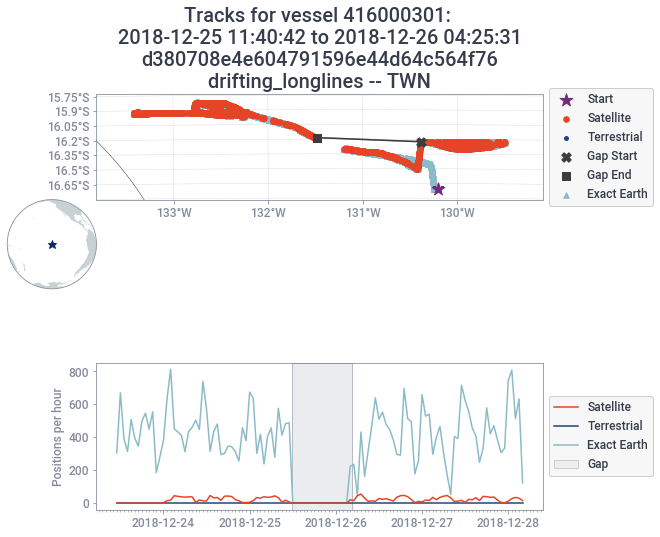

In [17]:
fig, axes = plot_gap.plot_gap(gap_id, gaps_data=df_gaps, hourly_data=df_hourly_all, performance_data=df_performance, \
                                     positions_gfw=df_gap_positions_gfw, positions_ee=df_gap_positions_ee, show_all_gaps=False, \
                                     table_type='none')

### Plot with a simplified attribute table (table_type = 'basic')

This was designed for tracks that do not have Exact Earth data or when you do not want additional information about the Exact Earth positions.

416000301
d380708e4e604791596e44d64c564f76


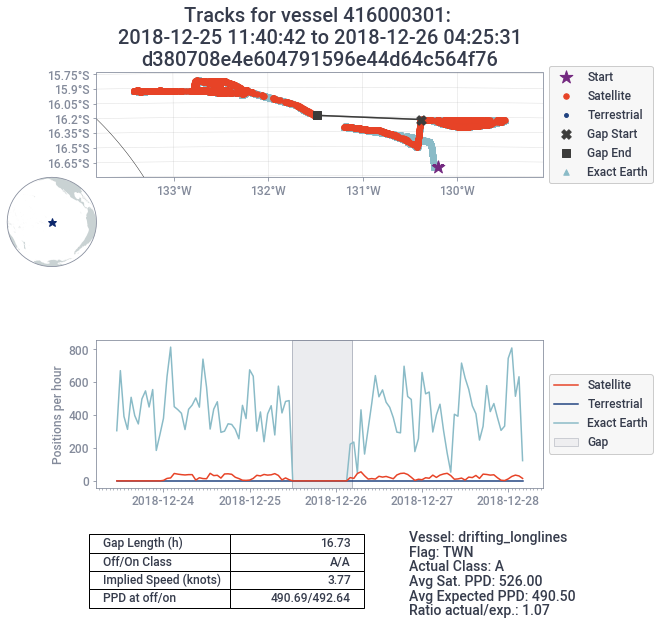

In [19]:
fig, axes = plot_gap.plot_gap(gap_id, gaps_data=df_gaps, hourly_data=df_hourly_all, performance_data=df_performance, \
                                     positions_gfw=df_gap_positions_gfw, positions_ee=df_gap_positions_ee, show_all_gaps=False, \
                                     table_type='basic')

### Plot with a full Exact Earth attribute table (table_type = 'ee')

This was designed for tracks that have Exact Earth data and the user is trying to investigate the gap model.

416000301
d380708e4e604791596e44d64c564f76


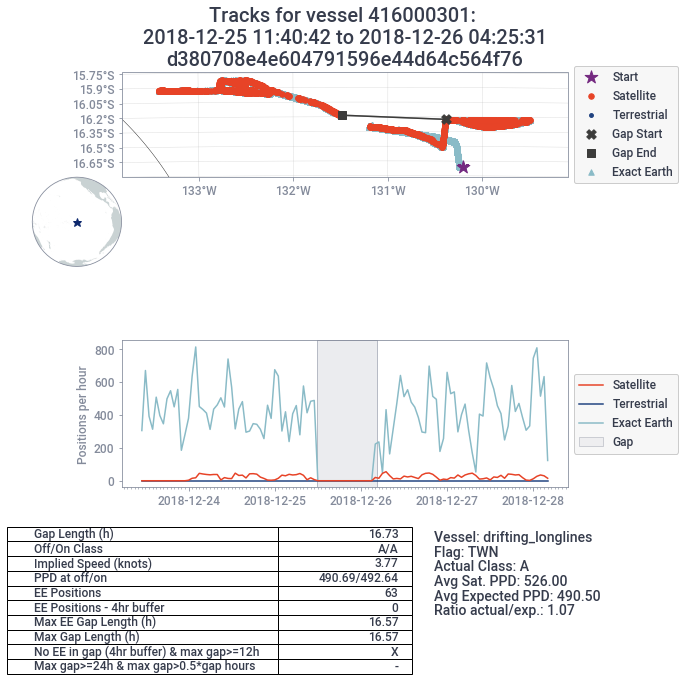

In [20]:
fig, axes = plot_gap.plot_gap(gap_id, gaps_data=df_gaps, hourly_data=df_hourly_all, performance_data=df_performance, \
                                     positions_gfw=df_gap_positions_gfw, positions_ee=df_gap_positions_ee, show_all_gaps=False, \
                                     table_type='ee')

### Remove the Exact Earth data by omitting positions_ee parameter (or explicitly setting to None)

416000301
d380708e4e604791596e44d64c564f76


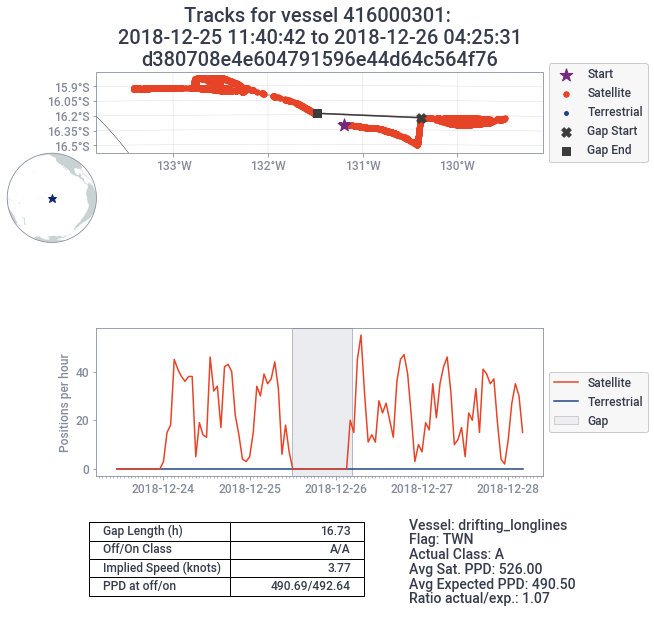

In [21]:
fig, axes = plot_gap.plot_gap(gap_id, gaps_data=df_gaps, hourly_data=df_hourly_all, performance_data=df_performance, \
                                     positions_gfw=df_gap_positions_gfw, show_all_gaps=False, \
                                     table_type='basic')

### Remove performance metrics by omitting performance_data (or explicitly setting to None)

416000301
d380708e4e604791596e44d64c564f76


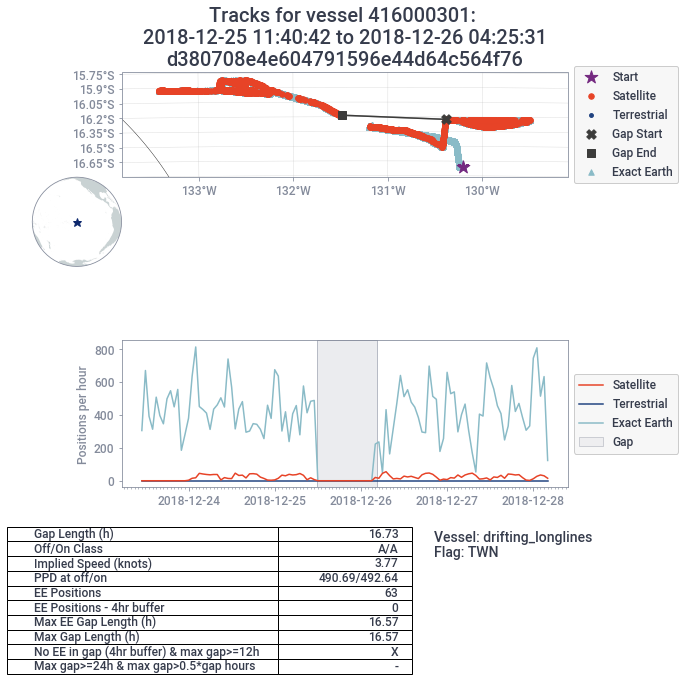

In [16]:
fig, axes = plot_gap.plot_gap(gap_id, gaps_data=df_gaps, hourly_data=df_hourly_all, \
                                     positions_gfw=df_gap_positions_gfw, positions_ee=df_gap_positions_ee, show_all_gaps=False, \
                                     table_type='ee')